In [175]:
import numpy as np
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns

import numpy as np
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor, LassoLars
from sklearn import metrics

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from statsmodels.base.model import Results
import statsmodels.base.wrapper as wrap
from statsmodels.tools.decorators import cache_readonly

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
for i in range(2014,2020):
    df_i = pickle.load(open(f'final_{i}.pickle', "rb" ))

In [104]:
sns.set_palette('tab20b')

In [4]:
df_2014 = pickle.load(open('final_2014.pickle', "rb" ))
df_2015 = pickle.load(open('final_2015.pickle', "rb" ))
df_2016 = pickle.load(open('final_2016.pickle', "rb" ))
df_2017 = pickle.load(open('final_2017.pickle', "rb" ))
df_2018 = pickle.load(open('final_2018.pickle', "rb" ))
df_2019 = pickle.load(open('final_2019.pickle', "rb" ))



In [235]:
frames = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019]
df = pd.concat(frames)
df = df.drop(columns = ['line_x','line_y','line']) #this line may be commented out once data issues around line are figured out

In [ ]:
#only ran once when files were all good. no need to run this again...
#with open(f'final_df.pickle', 'wb') as handle:
#    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [236]:
df

,url,Team,Date,Opponent,Spread,Win_Loss,Home,Away,GP,Wins,Tm,Opp,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,ORtg,DRtg,Pace,FTr,3PAr,TS%,TRB%,AST%,STL%,BLK%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,P_S,FG_S,FGA_S,FG%_S,3P_S,3PA_S,3P%_S,FT_S,FTA_S,FT%_S,TRB_S,AST_S,STL_S,BLK_S,TOV_S,PF_S,FTr_S,3PAr_S,TS%_S,TRB%_S,AST%_S,STL%_S,BLK%_S,Team_vs,Date_vs,Opponent_vs,Spread_vs,Win_Loss_vs,Home_vs,Away_vs,GP_vs,Wins_vs,Tm_vs,Opp_vs,FG_vs,FGA_vs,FG%_vs,3P_vs,3PA_vs,3P%_vs,FT_vs,FTA_vs,FT%_vs,ORB_vs,TRB_vs,AST_vs,STL_vs,BLK_vs,TOV_vs,PF_vs,ORtg_vs,DRtg_vs,Pace_vs,FTr_vs,3PAr_vs,TS%_vs,TRB%_vs,AST%_vs,STL%_vs,BLK%_vs,OeFG%_vs,OTOV%_vs,ORB%_vs,OFT/FGA_vs,DeFG%_vs,DTOV%_vs,DRB%_vs,DFT/FGA_vs,P_S_vs,FG_S_vs,FGA_S_vs,FG%_S_vs,3P_S_vs,3PA_S_vs,3P%_S_vs,FT_S_vs,FTA_S_vs,FT%_S_vs,TRB_S_vs,AST_S_vs,STL_S_vs,BLK_S_vs,TOV_S_vs,PF_S_vs,FTr_S_vs,3PAr_S_vs,TS%_S_vs,TRB%_S_vs,AST%_S_vs,STL%_S_vs,BLK%_S_vs
0,/cbb/boxscores/2013-11-08-air-force.html,Air Force,2013-11-08,Army,11.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Army,2013-11-08,Air Force,-11.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/cbb/boxscores/2013-11-08-akron.html,Akron,2013-11-08,Coastal Carolina,9.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coastal Carolina,2013-11-08,Akron,-9.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/cbb/boxscores/2013-11-08-alabama.html,Alabama,2013-11-08,Oklahoma,-9.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oklahoma,2013-11-08,Alabama,9.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/cbb/boxscores/2013-11-08-arizona-state.html,UMBC,2013-11-08,Arizona State,-35.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arizona State,2013-11-08,UMBC,35.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/cbb/boxscores/2013-11-08-arizona.html,Arizona,2013-11-08,Cal Poly,11.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cal Poly,2013-11-08,Arizona,-11.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [18]:
cols = df.columns.tolist()
target = 'Spread'
all_predictors = ['Home', 'Away', 'Wins', 'Tm', 'Opp', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
                   'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%',
                   'STL%', 'BLK%', 'OeFG%', 'OTOV%', 'ORB%', 'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%', 'DFT/FGA', 'P_S', 'FG_S',
                   'FGA_S', 'FG%_S', '3P_S', '3PA_S', '3P%_S', 'FT_S', 'FTA_S', 'FT%_S', 'TRB_S', 'AST_S', 'STL_S', 'BLK_S',
                   'TOV_S', 'PF_S', 'FTr_S', '3PAr_S', 'TS%_S', 'TRB%_S', 'AST%_S', 'STL%_S', 'BLK%_S',
                   'Home_vs', 'Away_vs', 'Wins_vs', 'Tm_vs', 'Opp_vs', 'FG_vs', 'FGA_vs', 'FG%_vs', '3P_vs', '3PA_vs',
                   '3P%_vs', 'FT_vs', 'FTA_vs', 'FT%_vs', 'ORB_vs', 'TRB_vs', 'AST_vs', 'STL_vs', 'BLK_vs', 'TOV_vs',
                   'PF_vs', 'ORtg_vs', 'DRtg_vs', 'Pace_vs', 'FTr_vs', '3PAr_vs', 'TS%_vs', 'TRB%_vs', 'AST%_vs',
                   'STL%_vs', 'BLK%_vs', 'OeFG%_vs', 'OTOV%_vs', 'ORB%_vs', 'OFT/FGA_vs', 'DeFG%_vs', 'DTOV%_vs',
                   'DRB%_vs', 'DFT/FGA_vs', 'P_S_vs', 'FG_S_vs', 'FGA_S_vs', 'FG%_S_vs', '3P_S_vs', '3PA_S_vs',
                   '3P%_S_vs', 'FT_S_vs', 'FTA_S_vs', 'FT%_S_vs', 'TRB_S_vs', 'AST_S_vs', 'STL_S_vs', 'BLK_S_vs',
                   'TOV_S_vs', 'PF_S_vs', 'FTr_S_vs', '3PAr_S_vs', 'TS%_S_vs', 'TRB%_S_vs', 'AST%_S_vs', 'STL%_S_vs',
                   'BLK%_S_vs']
info_cols = ['url','Team','Date','Opponent','Win_Loss','GP','GP_vs']

In [10]:
def TVT_split(df, train_min = 12, val_min = 24, test_min = 28):
    
    df_train = df[(df.GP >= train_min) & (df.GP_vs >= train_min) & (df.GP <= (val_min -1))] 
    df_val = df[(df.GP >= val_min) & (df.GP <= (test_min -1))] 
    df_test = df[df.GP >= test_min]
    
    
    total = len(df)
    train = len(df_train)
    val = len(df_val)
    test = len(df_test)
    mature = train + val + test
    immature = total - mature
    
    
    splits = [['dataset','games','percent of total'],['total', total ,'1'],['immature', immature, immature/total],
               ['mature', mature, mature/total], ['dataset','games','percent of mature'], ['train', train, train/mature],
               ['val', val, val/mature], ['test', test, test/mature]]
 
    print(splits)
    return df_train, df_val, df_test

In [11]:
df_train_all, df_val_all, df_test_all = TVT_split(df)

[['dataset', 'games', 'percent of total'], ['total', 33354, '1'], ['immature', 13445, 0.40310007795166997], ['mature', 19909, 0.5968999220483301], ['dataset', 'games', 'percent of mature'], ['train', 12020, 0.6037470490732835], ['val', 4093, 0.2055854136320257], ['test', 3796, 0.19066753729469085]]


In [12]:
df_train_all

,url,Team,Date,Opponent,Spread,Win_Loss,Home,Away,GP,Wins,Tm,Opp,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,ORtg,DRtg,Pace,FTr,3PAr,TS%,TRB%,AST%,STL%,BLK%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,P_S,FG_S,FGA_S,FG%_S,3P_S,3PA_S,3P%_S,FT_S,FTA_S,FT%_S,TRB_S,AST_S,STL_S,BLK_S,TOV_S,PF_S,FTr_S,3PAr_S,TS%_S,TRB%_S,AST%_S,STL%_S,BLK%_S,Team_vs,Date_vs,Opponent_vs,Spread_vs,Win_Loss_vs,Home_vs,Away_vs,GP_vs,Wins_vs,Tm_vs,Opp_vs,FG_vs,FGA_vs,FG%_vs,3P_vs,3PA_vs,3P%_vs,FT_vs,FTA_vs,FT%_vs,ORB_vs,TRB_vs,AST_vs,STL_vs,BLK_vs,TOV_vs,PF_vs,ORtg_vs,DRtg_vs,Pace_vs,FTr_vs,3PAr_vs,TS%_vs,TRB%_vs,AST%_vs,STL%_vs,BLK%_vs,OeFG%_vs,OTOV%_vs,ORB%_vs,OFT/FGA_vs,DeFG%_vs,DTOV%_vs,DRB%_vs,DFT/FGA_vs,P_S_vs,FG_S_vs,FGA_S_vs,FG%_S_vs,3P_S_vs,3PA_S_vs,3P%_S_vs,FT_S_vs,FTA_S_vs,FT%_S_vs,TRB_S_vs,AST_S_vs,STL_S_vs,BLK_S_vs,TOV_S_vs,PF_S_vs,FTr_S_vs,3PAr_S_vs,TS%_S_vs,TRB%_S_vs,AST%_S_vs,STL%_S_vs,BLK%_S_vs
1806,/cbb/boxscores/2013-12-22-oakland.html,Oakland,2013-12-22,Robert Morris,6.0,1.0,1.0,0.0,12.0,0.166667,69.333333,77.666667,23.583333,57.916667,0.410833,8.083333,23.250000,0.346667,14.083333,19.000000,0.748167,8.416667,28.666667,13.250000,7.083333,1.666667,11.666667,20.750000,98.450000,110.316667,69.891667,0.333250,0.402333,0.519500,44.025000,55.508333,9.925000,4.850000,0.481417,14.875000,24.400000,0.246083,0.543917,16.508333,66.691667,0.320750,-8.333333,-2.833333,2.083333,-0.064417,0.416667,2.166667,-0.020500,-3.083333,-4.833333,0.023167,-7.583333,-2.750000,0.666667,-2.083333,-1.666667,2.916667,0.012593,0.184922,-0.066444,87.050000,-0.039187,0.007480,-0.029639,Robert Morris,2013-12-22,Oakland,-6.0,0.0,0.0,1.0,12.0,0.416667,73.000000,77.166667,24.916667,57.333333,0.440417,8.250000,20.250000,0.412917,14.916667,22.333333,0.651083,9.583333,30.166667,13.750000,5.500000,1.750000,11.750000,22.916667,104.625000,110.200000,69.966667,0.401417,0.353083,0.543667,47.791667,55.475000,7.833333,5.116667,0.513583,14.916667,29.108333,0.268250,0.517417,15.458333,65.600000,0.416250,-4.166667,0.333333,3.833333,-0.017417,1.833333,0.416667,0.097500,-6.666667,-8.250000,-0.063083,-3.333333,0.000000,0.083333,-2.750000,-0.750000,3.750000,-0.014826,0.036498,-0.032256,94.583333,0.000945,0.001365,-0.038209
1853,/cbb/boxscores/2013-12-27-northwestern.html,Northwestern,2013-12-27,DePaul,-1.0,0.0,1.0,0.0,12.0,0.583333,67.583333,63.750000,22.250000,52.666667,0.425000,7.083333,21.583333,0.322667,16.000000,22.166667,0.720750,7.333333,31.916667,13.250000,4.083333,3.166667,11.083333,19.500000,100.616667,95.241667,66.841667,0.431333,0.415750,0.535583,49.308333,59.816667,6.166667,7.816667,0.494583,14.941667,23.783333,0.312833,0.455167,14.058333,73.391667,0.283667,3.833333,0.166667,-1.333333,0.013333,2.333333,6.416667,0.005750,1.166667,-1.250000,0.074750,-0.583333,1.666667,-1.583333,-1.416667,0.500000,-1.000000,0.147672,0.275964,0.036395,97.616667,0.023985,-0.022655,-0.023818,DePaul,2013-12-27,Northwestern,1.0,1.0,0.0,1.0,12.0,0.583333,75.416667,72.416667,26.000000,58.083333,0.449583,5.833333,16.083333,0.369583,17.583333,25.000000,0.699000,12.083333,33.000000,12.333333,6.833333,4.833333,13.833333,20.500000,104.675000,101.558333,71.400000,0.444333,0.280667,0.541417,52.841667,47.150000,9.266667,12.441667,0.500250,16.466667,37.475000,0.315083,0.503000,17.041667,70.050000,0.316500,3.000000,0.916667,2.250000,-0.008000,0.750000,-0.250000,0.050167,0.416667,0.916667,-0.001833,3.833333,1.000000,0.416667,0.000000,-0.166667,-0.750000,0.127812,-0.034268,-0.008817,104.683333,0.011638,0.004226,-0.000316
1859,/cbb/boxscores/2013-12-28-arizona-state.html,Arizona State,2013-12-28,UC-Irvine,13.0,1.0,1.0,0.0,12.0,0.833333,79.750000,64.083333,28.500000,58.000000,0.490833,9.083333,22.583333,0.401417,13.666667,20.166667,0.662000,8.416667,36.166667,17.000000,5.083333,7.083333,10.166667,17.166667,114.033333,92.366667,69.800000,0.352167,0.393750,0.591667,51.741667,60.683333,7.150000,16.341667,0.570583,13.075000,26.241667,0.241417,0.427417,13.308333,72.916667,0.206917,15.666667,5.166667,

In [13]:
df_train = df_train_all.dropna()
df_val = df_val_all.dropna()
df_test = df_test_all.dropna()

In [14]:
print([len(df_train), len(df_val), len(df_test)])

[12018, 4089, 3793]


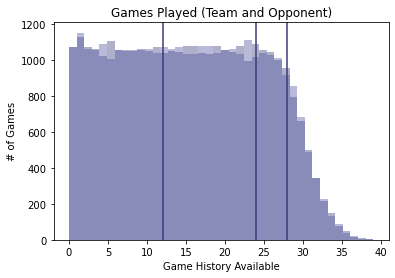

In [259]:
sns.distplot(df.GP_vs, kde=False) 
sns.distplot(df.GP, kde=False) 
plt.axvline(12, 0,1200)
plt.axvline(24, 0,1200)
plt.axvline(28, 0,1200)
plt.title('Games Played (Team and Opponent)')
plt.xlabel('Game History Available')
plt.ylabel('# of Games')
plt.savefig('games_played.png')
plt.show()


In [256]:
len(df.Team.unique())

353

## Keep this NaN log
tracks NaNs (outside of line) for games (this was earlier work done without the line column)
purely for informational purposes. no need to review

In [ ]:
# df_train.isnull().sum().sum()
# 6

In [ ]:
def find_NAN(df):
    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    return rows_with_NaN

In [ ]:
train_NaN = find_NAN(df_train)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
train_NaN

In [ ]:
# df_val.isnull().sum().sum()
# 12

In [ ]:
val_NaN = find_NAN(df_val)

In [ ]:
val_NaN

In [ ]:
# df_test.isnull().sum().sum()
# 74

In [ ]:
test_NaN = find_NAN(df_test)

In [ ]:
test_NaN

In [ ]:
#Note: Needed to drop NANS... due to timing. however, this only removes 2 games from train, 4 from validate, and 3 from test.
##unfortunately the one removed from test is the 2018 championship game =()

## Preprocessing

In [15]:
sc = StandardScaler()

In [16]:
def preprocess(df_train, df_val, df_test):
    '''
    pre-process the data...
    '''
    # get predictor columns
    X_train = df_train[all_predictors]
    X_val = df_val[all_predictors]
    X_test = df_test[all_predictors]
    
    #scale all predictors using training data
    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    X_test = sc.transform(X_test)
    
    #add constants
    X_train = sm.add_constant(X_train)
    X_val = sm.add_constant(X_val)
    X_test = sm.add_constant(X_test)
    
    #convert back to data frame
    X_train = pd.DataFrame(X_train, columns = ['const']+all_predictors,index = df_train.index)
    X_val = pd.DataFrame(X_val, columns = ['const']+all_predictors, index = df_val.index)
    X_test = pd.DataFrame(X_test, columns = ['const']+all_predictors, index = df_test.index)
        
        
    #get targets
    y_train = pd.DataFrame(df_train['Spread'])
    y_val = pd.DataFrame(df_val['Spread'])
    y_test = pd.DataFrame(df_test['Spread'])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [19]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess(df_train, df_val, df_test)

In [20]:
X_train

,const,Home,Away,Wins,Tm,Opp,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,ORtg,DRtg,Pace,FTr,3PAr,TS%,TRB%,AST%,STL%,BLK%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,P_S,FG_S,FGA_S,FG%_S,3P_S,3PA_S,3P%_S,FT_S,FTA_S,FT%_S,TRB_S,AST_S,STL_S,BLK_S,TOV_S,PF_S,FTr_S,3PAr_S,TS%_S,TRB%_S,AST%_S,STL%_S,BLK%_S,Home_vs,Away_vs,Wins_vs,Tm_vs,Opp_vs,FG_vs,FGA_vs,FG%_vs,3P_vs,3PA_vs,3P%_vs,FT_vs,FTA_vs,FT%_vs,ORB_vs,TRB_vs,AST_vs,STL_vs,BLK_vs,TOV_vs,PF_vs,ORtg_vs,DRtg_vs,Pace_vs,FTr_vs,3PAr_vs,TS%_vs,TRB%_vs,AST%_vs,STL%_vs,BLK%_vs,OeFG%_vs,OTOV%_vs,ORB%_vs,OFT/FGA_vs,DeFG%_vs,DTOV%_vs,DRB%_vs,DFT/FGA_vs,P_S_vs,FG_S_vs,FGA_S_vs,FG%_S_vs,3P_S_vs,3PA_S_vs,3P%_S_vs,FT_S_vs,FTA_S_vs,FT%_S_vs,TRB_S_vs,AST_S_vs,STL_S_vs,BLK_S_vs,TOV_S_vs,PF_S_vs,FTr_S_vs,3PAr_S_vs,TS%_S_vs,TRB%_S_vs,AST%_S_vs,STL%_S_vs,BLK%_S_vs
1806,1.0,0.986610,-0.982349,-1.575513,-0.332211,1.014029,-0.589549,0.248088,-0.964068,0.683756,0.770242,0.086203,-0.144118,-0.522694,1.259993,-0.327253,-1.142828,0.044408,0.687367,-1.515962,-0.749537,0.895252,-0.358495,1.424191,-0.065877,-0.629499,0.755068,-0.483875,-1.704948,0.541579,0.675637,-1.508203,-0.576552,-0.662190,-0.716587,-0.305541,1.226746,0.191154,-1.500698,1.173284,-1.031214,-0.944643,0.611108,-1.329822,0.237074,0.529290,-0.453140,-0.956380,-1.165073,0.458246,-1.675012,-0.940470,0.424939,-1.425401,-0.783588,1.300684,-1.313846,0.917713,-1.145346,-1.704948,-0.945745,0.337639,-1.426326,-0.982349,0.986610,-0.394868,0.241482,0.912586,-0.022676,0.083252,0.033634,0.776842,-0.048278,2.046503,0.201298,0.506621,-1.021561,0.342872,-0.633888,0.295701,-0.570185,-1.459645,-0.682532,1.972923,0.495563,1.375947,-0.031463,0.461912,-0.094946,0.249574,-0.630092,0.546981,-0.555016,-1.438565,0.335537,-0.626248,0.264250,0.176325,0.447284,-0.326458,-1.815791,2.963965,-0.513243,0.105757,1.096363,-0.349322,1.041559,0.095798,2.081528,-2.083383,-1.991297,-1.256153,-0.733960,0.000961,0.046687,-1.881321,-0.344289,1.670525,-1.674491,0.176622,-0.487800,-0.630092,0.023318,0.055185,-1.838906
1853,1.0,0.986610,-0.982349,0.387734,-0.605359,-1.238457,-1.146919,-1.215812,-0.491671,0.026368,0.317417,-0.626471,0.650842,0.457797,0.617952,-0.964255,-0.060418,0.044408,-1.708997,-0.244477,-1.120937,0.270433,-0.057325,-0.866652,-0.957988,0.941696,0.985549,-0.000053,-0.197337,1.297078,-1.540654,-0.536698,-0.204930,-0.627038,-0.846529,1.143964,-1.317162,-1.025472,0.335784,0.456707,0.463576,0.045642,-0.378104,0.259332,1.342031,1.563082,0.112219,0.362785,-0.302624,1.463199,-0.129080,0.552756,-1.008713,-0.971505,0.233654,-0.447121,0.462256,1.366797,0.781589,-0.197337,0.561891,-1.019775,-1.147430,-0.982349,0.986610,0.386240,0.611483,0.162988,0.422546,0.286706,0.335159,-0.787705,-1.165432,0.766151,1.301252,1.327976,0.115952,1.800754,0.299334,-0.373255,0.496276,1.175984,0.660919,0.772736,0.502490,0.084024,0.378504,1.150067,-1.340367,0.182406,0.801213,-0.900784,0.290540,0.980016,-0.036418,0.197241,2.020123,1.194581,0.039591,0.451181,-0.591962,1.071162,0.361370,0.296057,0.639195,-0.159763,0.424048,-0.064170,1.072343,0.125403,0.217732,-0.040338,0.836044,0.336047,0.261376,0.000924,-0.069414,-0.327664,0.200476,-0.166488,-0.052985,0.801213,0.276005,0.185101,-0.014206
1859,1.0,0.986610,-0.982349,1.565682,1.293667,-1.184506,1.465749,0.271324,1.703586,1.341144,0.589112,1.711992,-0.316935,-0.161461,-0.757850,-0.327253,1.355041,1.824948,-0.910209,3.075512,-1.704566,-0.895895,1.807607,-1.303546,-0.092689,-0.326474,0.607618,1.687055,0.497021,1.449055,-0.960782,2.255016,1.940124,-1.611291,-0.328516,-0.406880,-2.112581,-1.397909,0.205585,-1.026366,1.917413,1.696116,-0.788265,2.127823,2.398946,1.259025,2.784660,0.362785,0.118573,0.248814,0.551866,2.158679,0.212546,2.375973,-0.274967,-0.781807,0.428555,0.265387,2.476652,0.497021,2.186031,0.219166,2.383442,-0.982349,0.986610,-0.004314,0.483897,-0.047426,0.902016,0.060646,1.398720,-0.679805,-1.254804,0.734142,-0.073690,0.942966,-1.864310,0.342872,1.369795,1.476211,-0.636839,2.885581,0.177277,0.483036,0.567139,-0.268546,0.1

In [21]:
y_train

,Spread
1806,6.0
1853,-1.0
1859,13.0
1863,-4.0
1886,7.0
...,...
4886,-2.0
4908,-8.0
4913,-8.0
4929,-9.0


## Helper Functions for Modeling

In [138]:
def conf_matrix(pred):
    TP = len(pred[(pred.Actual>0)&(pred.Estimate>0)])
    TN = len(pred[(pred.Actual<0)&(pred.Estimate<0)])
    FP = len(pred[(pred.Actual<0)&(pred.Estimate>0)])
    FN = len(pred[(pred.Actual>0)&(pred.Estimate<0)])
    Z = TP+TN+FP+FN
    Matrix = pd.DataFrame([[TP,FP,TN,FN,TP+TN,FP+FN],[TP/Z,FP/Z,TN/Z,FN/Z,(TP+TN)/Z,(FP+FN)/Z]], columns=['TP','FP','TN','FN','T','F'])
    return Matrix

In [158]:
def train_diag(columns, X_train, y_train, df_train):
    '''
    Runs OLS regression on training set.
    Outputs the results and diagnostic information.
    
    '''
    X_train_mod = pd.DataFrame(X_train, columns = columns,index = df_train.index)
    model = sm.OLS(y_train, X_train_mod)

    fit = model.fit()
    print(fit.summary())
    
    ypred = fit.predict(X_train_mod)
    prediction = pd.concat([y_train, ypred, abs(y_train.Spread-ypred)],axis=1)
    prediction.columns = ["Actual","Estimate","Absolute Error"]
    print(prediction)
    
    res_mat = conf_matrix(prediction)
    print(res_mat)

    #QQ plot
    plot = stats.probplot(fit.resid, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
    ## Observed vs Predicted
    plot = sns.jointplot(x= prediction.Actual, y = fit.fittedvalues, xlim = [-60,60], ylim = [-60,60], 
                     alpha = 0.1).set_axis_labels("Actual", "Predicted");
    
    plot = sns.jointplot(x= fit.resid, y = fit.fittedvalues, xlim = [-60,60], ylim = [-60,60], 
                     alpha = 0.1).set_axis_labels("Residuals", "Predicted");  
    


    return model, fit, ypred, prediction, res_mat

## Initial Model - OLS using all stats

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     50.73
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        22:08:23   Log-Likelihood:                -45801.
No. Observations:               12018   AIC:                         9.184e+04
Df Residuals:                   11899   BIC:                         9.272e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0809      0.100      0.807      0.4

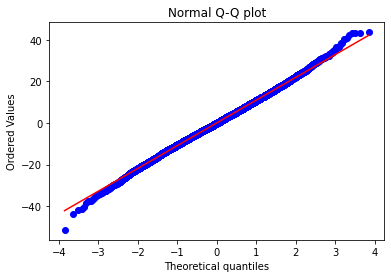

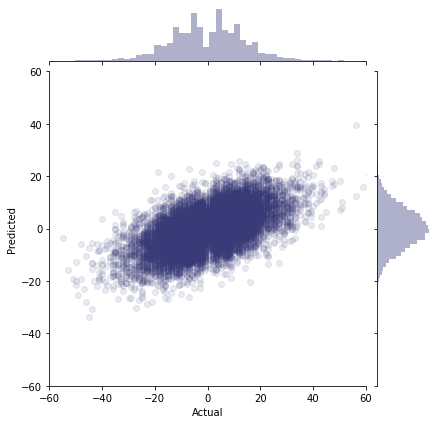

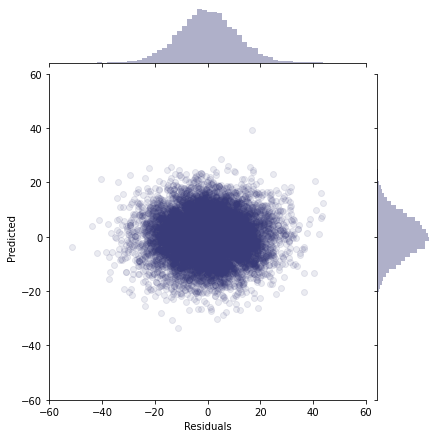

In [162]:
model1, fit1, ypred1, prediction1, res_mat1 = train_diag(['const']+all_predictors, X_train, y_train, df_train)

In [213]:
valpred = fit1.predict(X_val)
val_prediction = pd.concat([y_val, valpred, abs(y_val.Spread-valpred)], axis=1)
val_prediction.columns = ["Actual","Estimate","Absolute Error"]
val_prediction.describe()

,Actual,Estimate,Absolute Error
count,4089.000000,4089.000000,4089.000000
mean,-0.102715,0.157835,8.654217
std,13.592825,7.594686,6.711883
min,-58.000000,-26.345439,0.003046
25%,-9.000000,-4.862265,3.403794
50%,-1.000000,0.224317,7.216346
75%,9.000000,5.157497,12.343295
max,58.000000,28.013907,42.813315


In [215]:
val_mat = conf_matrix(val_prediction)
val_mat

,TP,FP,TN,FN,T,F
0,1478.000000,623.00000,1428.00000,560.000000,2906.000000,1183.000000
1,0.361458,0.15236,0.34923,0.136953,0.710687,0.289313


In [33]:
testpred = fit1.predict(X_test)
test_prediction = pd.concat([y_test, testpred, abs(y_test.Spread-testpred)], axis=1)
test_prediction.columns = ["Actual","Estimate","Absolute Error"]
test_prediction.describe()

,Actual,Estimate,Absolute Error
count,3793.000000,3793.000000,3793.000000
mean,0.520432,1.289276,8.787969
std,13.134374,6.609523,6.924095
min,-45.000000,-25.315369,0.000859
25%,-8.000000,-3.058382,3.402856
50%,1.000000,1.318958,7.218439
75%,9.000000,5.614725,12.595402
max,61.000000,32.684491,41.118661


In [34]:
test_mat = error_matrix(test_prediction)
test_mat

[1483, 723, 1105, 482]

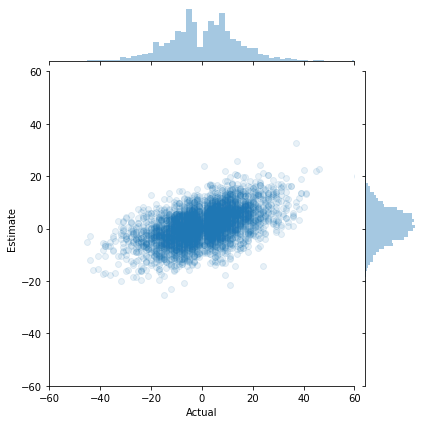

In [35]:
plot = sns.jointplot(x= test_prediction.Actual, y = test_prediction.Estimate, xlim = [-60,60], ylim = [-60,60], 
                     alpha = 0.1);

## Lasso Regression

In [36]:
fit_lasso = model.fit_regularized(alpha = 0.06,L1_wt = 0,start_params=fit1.params)

In [37]:
final = sm.regression.linear_model.OLSResults(model,fit_lasso.params,model.normalized_cov_params)

In [38]:
print(final.summary())

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     49.54
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:31:38   Log-Likelihood:                -45848.
No. Observations:               12018   AIC:                         9.193e+04
Df Residuals:                   11899   BIC:                         9.281e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0763      0.101      0.758      0.4

In [39]:
params = list(zip(final.params,['const']+all_predictors))

In [40]:
params

[(0.07630064337456456, 'const'),
 (0.724211945729708, 'Home'),
 (-0.8665309485264979, 'Away'),
 (0.6207205809300408, 'Wins'),
 (0.18912967086837232, 'Tm'),
 (-0.2822721132663162, 'Opp'),
 (0.1867071295336493, 'FG'),
 (0.032261810823762185, 'FGA'),
 (0.31015565998373656, 'FG%'),
 (-0.017796523568313162, '3P'),
 (0.3612064297174929, '3PA'),
 (-0.020874702115270347, '3P%'),
 (0.15162549642987042, 'FT'),
 (-0.15032020272028496, 'FTA'),
 (0.29805873148278017, 'FT%'),
 (-0.14032895120430763, 'ORB'),
 (-0.021775024918152468, 'TRB'),
 (-0.006751601127773777, 'AST'),
 (0.21078039126717232, 'STL'),
 (0.05316536455740535, 'BLK'),
 (-0.5422363129686992, 'TOV'),
 (0.5071789922197476, 'PF'),
 (0.37286004259761696, 'ORtg'),
 (-0.2793851157700198, 'DRtg'),
 (-0.22815503311737206, 'Pace'),
 (-0.06601641803466558, 'FTr'),
 (0.23019962895527812, '3PAr'),
 (0.2737709018452116, 'TS%'),
 (0.4015571320239244, 'TRB%'),
 (-0.05121707758235803, 'AST%'),
 (0.3415130853180437, 'STL%'),
 (0.34300903539827604, 'BLK

In [41]:
frames = []
for n in np.arange(0, 1, 0.01).tolist():
    results_fr = model.fit_regularized(L1_wt=0, alpha=n, start_params=fit1.params)

    results_fr_fit = sm.regression.linear_model.OLSResults(model, 
                                                           results_fr.params)
    frames.append(np.append(results_fr.params, np.mean(abs(y_val.Spread-results_fr.predict(X_val)))))
    df = pd.DataFrame(frames, columns=['const']+all_predictors + ['mae*'])
df.index=np.arange(0, 1, 0.01).tolist()
df.index.name = 'alpha*'
df.T

alpha*,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
const,8.748109e-02,0.080078,0.079293,0.078523,0.077768,0.077027,0.076301,0.075588,0.074888,0.074201,0.073526,0.072864,0.072213,0.071574,0.070946,0.070329,0.069723,0.069127,0.068541,0.067965,0.067399,0.066842,0.066294,0.065755,0.065225,0.064703,0.064189,0.063684,0.063186,0.062697,0.062214,0.061739,0.061272,0.060811,0.060357,0.059910,0.059470,0.059036,0.058608,0.058186,0.057770,0.057361,0.056957,0.056559,0.056166,0.055778,0.055396,0.055020,0.054648,0.054281,0.053919,0.053562,0.053210,0.052862,0.052519,0.052180,0.051845,0.051515,0.051189,0.050867,0.050549,0.050235,0.049925,0.049619,0.049316,0.049017,0.048722,0.048430,0.048142,0.047857,0.047576,0.047297,0.047022,0.046751,0.046482,0.046216,0.045954,0.045694,0.045437,0.045184,0.044933,0.044684,0.044439,0.044196,0.043956,0.043718,0.043483,0.043251,0.043021,0.042793,0.042568,0.042345,0.042124,0.041906,0.041690,0.041476,0.041265,0.041055,0.040848,0.040643
Home,7.252730e+13,0.535841,0.630232,0.673879,0.698485,0.713910,0.724212,0.731369,0.736457,0.740114,0.742740,0.744599,0.745875,0.746695,0.747154,0.747322,0.747253,0.746989,0.746561,0.745996,0.745314,0.744534,0.743668,0.742730,0.741728,0.740671,0.739566,0.738419,0.737236,0.736020,0.734775,0.733506,0.732215,0.730904,0.729576,0.728233,0.726877,0.725509,0.724132,0.722745,0.721351,0.719950,0.718543,0.717132,0.715716,0.714298,0.712876,0.711453,0.710028,0.708601,0.707175,0.705748,0.704321,0.702895,0.701469,0.700045,0.698622,0.697200,0.695781,0.694363,0.692948,0.691535,0.690125,0.688717,0.687312,0.685911,0.684512,0.683117,0.681725,0.680336,0.678951,0.677569,0.676192,0.674818,0.673447,0.672081,0.670718,0.669359,0.668005,0.666654,0.665308,0.663965,0.662627,0.661293,0.659962,0.658637,0.657315,0.655998,0.654685,0.653376,0.652071,0.650771,0.649475,0.648183,0.646896,0.645613,0.644334,0.643060,0.641790,0.640524
Away,-4.162406e+13,-1.075383,-0.976659,-0.928886,-0.900235,-0.880807,-0.866531,-0.855424,-0.846407,-0.838841,-0.832324,-0.826592,-0.821463,-0.816807,-0.812530,-0.808562,-0.804849,-0.801349,-0.798030,-0.794865,-0.791834,-0.788920,-0.786107,-0.783385,-0.780743,-0.778174,-0.775668,-0.773222,-0.770829,-0.768485,-0.766185,-0.763927,-0.761707,-0.759523,-0.757371,-0.755251,-0.753160,-0.751095,-0.749057,-0.747043,-0.745052,-0.743083,-0.741135,-0.739206,-0.737297,-0.735406,-0.733533,-0.731676,-0.729835,-0.728011,-0.726201,-0.724406,-0.722624,-0.720857,-0.719103,-0.717361,-0.715633,-0.713916,-0.712211,-0.710518,-0.708836,-0.707166,-0.705506,-0.703856,-0.702217,-0.700588,-0.698969,-0.697360,-0.695760,-0.694170,-0.692589,-0.691016,-0.689453,-0.687899,-0.686353,-0.684816,-0.683287,-0.681766,-0.680253,-0.678749,-0.677252,-0.675763,-0.674281,-0.672808,-0.671341,-0.669883,-0.668431,-0.666986,-0.665549,-0.664119,-0.662696,-0.661279,-0.659870,-0.658467,-0.657071,-0.655681,-0.654298,-0.652921,-0.651551,-0.650187
Wins,8.349134e-01,0.692081,0.675484,0.660335,0.646175,0.632981,0.620721,0.609336,0.598760,0.588920,0.579751,0.571189,0.563177,0.555665,0.548607,0.541963,0.535695,0.529772,0.524165,0.518847,0.513796,0.508991,0.504413,0.500044,0.495871,0.491878,0.488054,0.484386,0.480866,0.477482,0.474226,0.471091,0.468069,0.465153,0.462337,0.459615,0.456983,0.454434,0.451966,0.449572,0.447250,0.444996,0.442806,0.440678,0.438608,0.436593,0.434631,0.432720,0.430857,0.429040,0.427267,0.425536,0.423846,0.422194,0.420579,0.419000,0.417455,0.415943,0.414462,0.413012,0.411590,0.410197,0.408831,0.407491,0.406176,0.404886,0.403619,0.402374,0.401152,0.399950,0.398769,0.397608,0.396466

Text(0.5, 1.0, 'MSE')

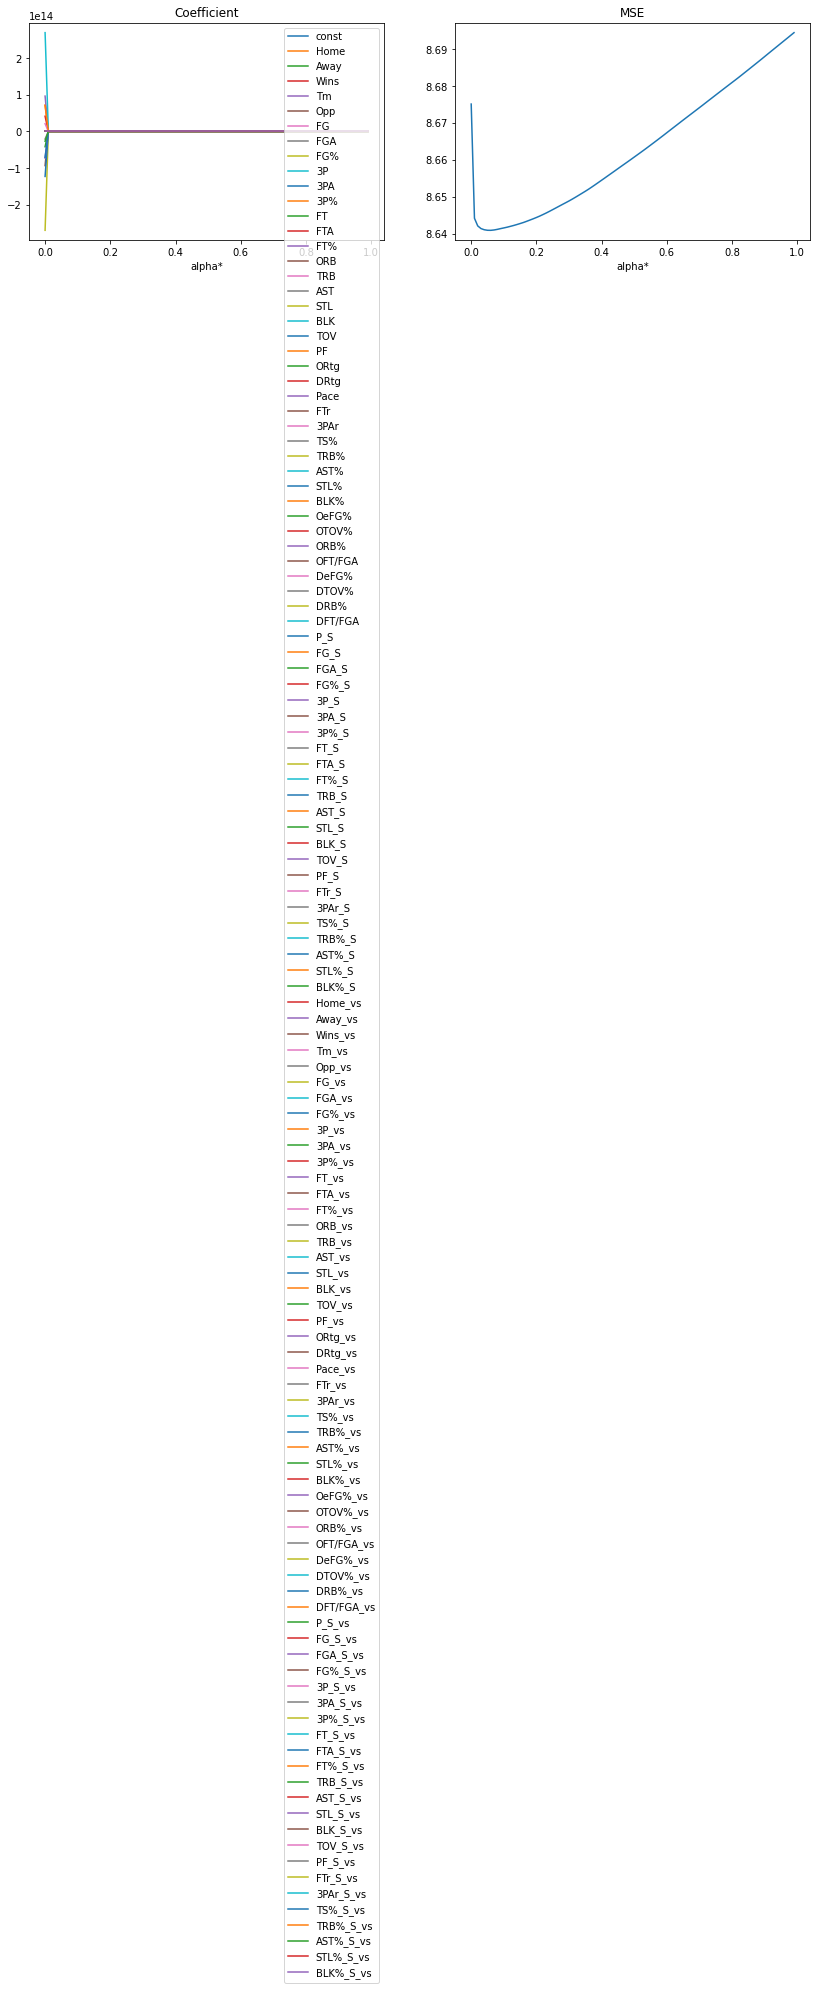

In [42]:

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0] = df.iloc[:100, :-1].plot(ax=ax[0])
ax[0].set_title('Coefficient')

ax[1] = df.iloc[:100, -1].plot(ax=ax[1])
ax[1].set_title('MSE')

## Linear Regression Model 3

This model is the "winner".

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     907.6
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:14:21   Log-Likelihood:                -46002.
No. Observations:               12018   AIC:                         9.202e+04
Df Residuals:                   12011   BIC:                         9.207e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0809      0.101      0.797      0.4

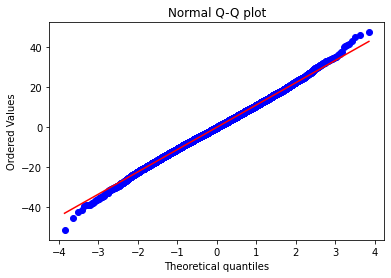

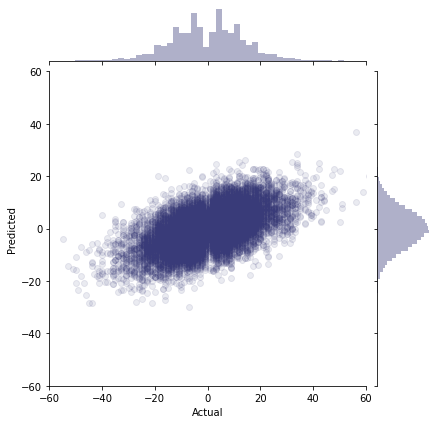

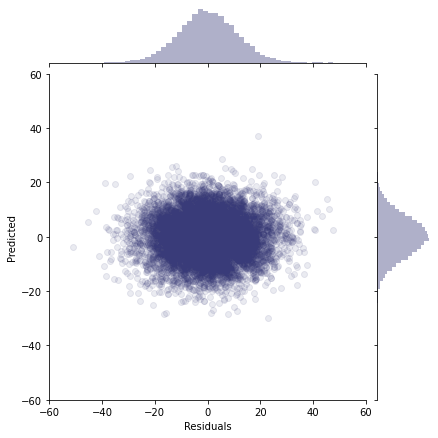

In [211]:
columns3 = ['const','Away','ORtg','ORtg_vs','DRtg_vs','DRtg','Wins']

model3, fit3, ypred3, prediction3, res_mat3 = train_diag(columns3, X_train, y_train, df_train)

In [ ]:
(x= test_prediction.Actual, y = test_prediction.Estimate, xlim = [-60,60], ylim = [-60,60], 
                     alpha = 0.1)

In [212]:
prediction3.describe()

,Actual,Estimate,Absolute Error
count,12018.000000,12018.000000,12018.000000
mean,0.080879,0.080879,8.771882
std,13.407912,7.488666,6.836641
min,-55.000000,-29.787052,0.001862
25%,-9.000000,-4.928424,3.414853
50%,1.000000,0.112005,7.282495
75%,9.000000,5.176633,12.565906
max,61.000000,37.064914,51.186400


In [214]:
valpred3 = fit3.predict(X_val[columns3])
val_prediction3 = pd.concat([y_val, valpred3, abs(y_val.Spread-valpred3)], axis=1)
val_prediction3.columns = ["Actual","Estimate","Absolute Error"]
val_prediction3.describe()

,Actual,Estimate,Absolute Error
count,4089.000000,4089.000000,4089.000000
mean,-0.102715,0.135743,8.666859
std,13.592825,7.303761,6.737260
min,-58.000000,-25.692575,0.001244
25%,-9.000000,-4.607583,3.420135
50%,-1.000000,0.192380,7.234100
75%,9.000000,5.065710,12.431541
max,58.000000,28.091438,44.695303


In [216]:
val_mat3 = conf_matrix(val_prediction3)
val_mat3

,TP,FP,TN,FN,T,F
0,1478.000000,625.000000,1426.000000,560.000000,2904.000000,1185.000000
1,0.361458,0.152849,0.348741,0.136953,0.710198,0.289802


                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     1272.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:38:25   Log-Likelihood:                -61598.
No. Observations:               16107   AIC:                         1.232e+05
Df Residuals:                   16100   BIC:                         1.233e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0216      0.087      0.247      0.8

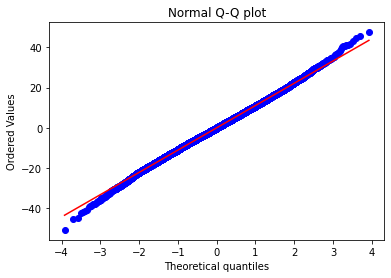

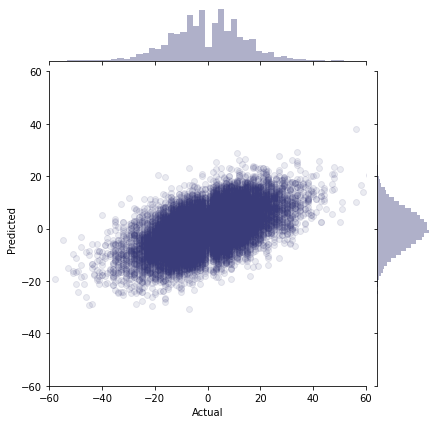

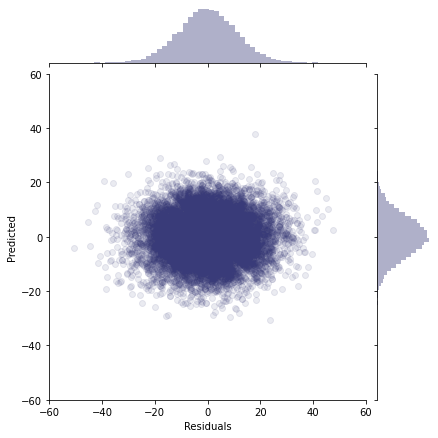

In [225]:
columns3 = ['const','Away','ORtg','ORtg_vs','DRtg_vs','DRtg','Wins']

X_frames = [X_train,X_val]
y_frames = [y_train,y_val]
df_frames = [df_train,df_val]

X_train_mod = pd.concat(X_frames, ignore_index=True)
y_train_mod = pd.concat(y_frames, ignore_index=True)
df_train_mod= pd.concat(df_frames, ignore_index=True)


model_best, fit_best, ypred_best, prediction_best, res_mat_best = train_diag(columns3, X_train_mod, y_train_mod, df_train_mod)

In [227]:
prediction_best.describe()

,Actual,Estimate,Absolute Error
count,16107.000000,16107.000000,16107.000000
mean,0.034271,0.034271,8.743855
std,13.454909,7.629653,6.809055
min,-58.000000,-30.567381,0.000158
25%,-9.000000,-5.009911,3.424736
50%,1.000000,0.098841,7.304126
75%,9.000000,5.216704,12.521801
max,61.000000,37.993224,50.815698


In [228]:
best_pred = fit_best.predict(X_test[columns3])
best_prediction = pd.concat([y_test, best_pred, abs(y_test.Spread-best_pred)], axis=1)
best_prediction.columns = ["Actual","Estimate","Absolute Error"]
best_prediction.describe()

,Actual,Estimate,Absolute Error
count,3793.000000,3793.000000,3793.000000
mean,0.520432,1.551742,8.897429
std,13.134374,6.581787,6.967230
min,-45.000000,-23.677550,0.017313
25%,-8.000000,-2.823593,3.519573
50%,1.000000,1.703832,7.301705
75%,9.000000,5.844217,12.508879
max,61.000000,31.709352,43.556808


In [229]:
best_mat = conf_matrix(best_prediction)
best_mat

,TP,FP,TN,FN,T,F
0,1516.000000,766.000000,1062.000000,449.000000,2578.000000,1215.000000
1,0.399684,0.201951,0.279989,0.118376,0.679673,0.320327


## Model 4

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     2024.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:56:16   Log-Likelihood:                -46504.
No. Observations:               12018   AIC:                         9.301e+04
Df Residuals:                   12015   BIC:                         9.304e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0809      0.106      0.765      0.4

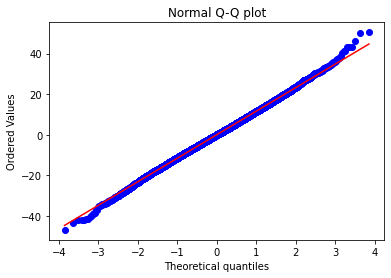

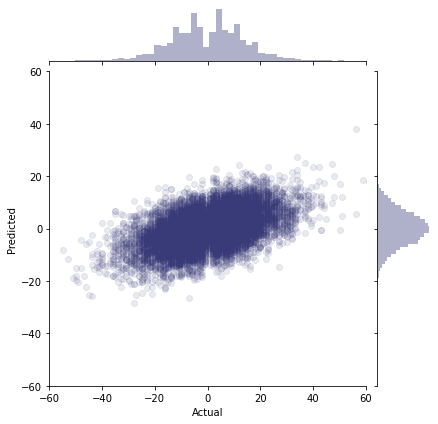

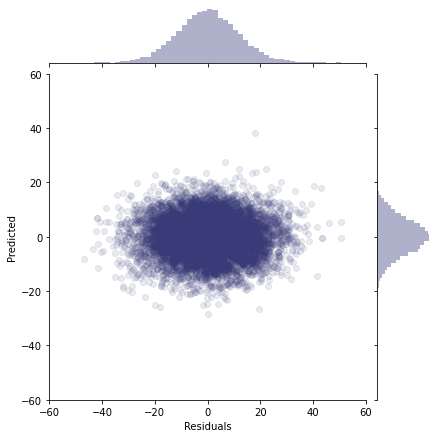

In [160]:
columns4 = ['const','P_S','P_S_vs']

model4, fit4, ypred4, prediction4, res_mat4 = train_diag(columns4, X_train, y_train, df_train)

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     198.2
Date:                Thu, 16 Jul 2020   Prob (F-statistic):          1.11e-203
Time:                        22:12:17   Log-Likelihood:                -47773.
No. Observations:               12018   AIC:                         9.556e+04
Df Residuals:                   12012   BIC:                         9.560e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0809      0.118      0.688      0.4

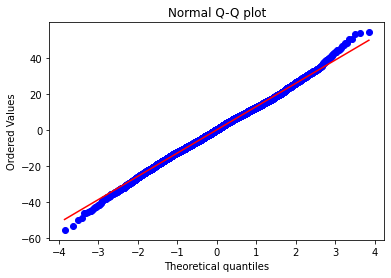

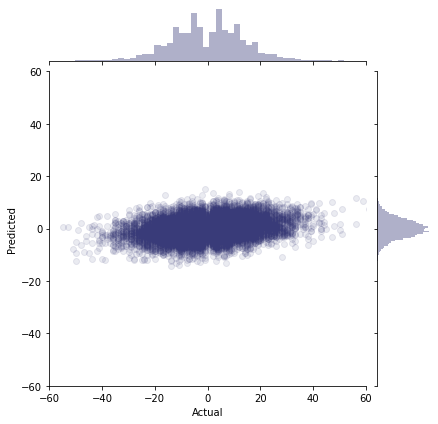

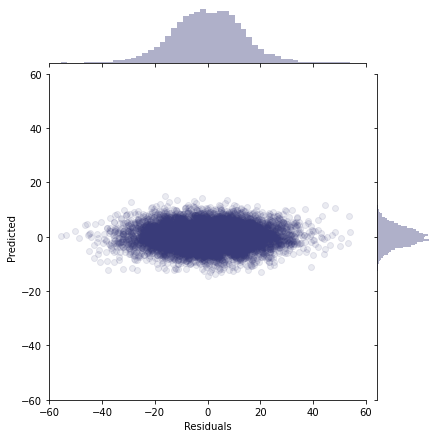

In [163]:
#took the highest coefficients from the all variable model

columns5 = ['const','P_S','Opp','FG','FG_S','FT_S']

model5, fit5, ypred5, prediction5, res_mat5 = train_diag(columns5, X_train, y_train, df_train)

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     554.6
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        22:16:38   Log-Likelihood:                -46360.
No. Observations:               12018   AIC:                         9.274e+04
Df Residuals:                   12009   BIC:                         9.280e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0809      0.105      0.774      0.4

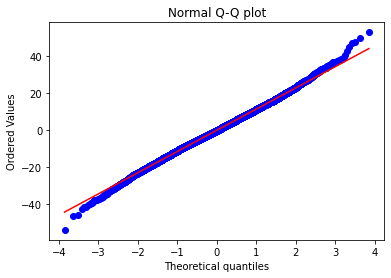

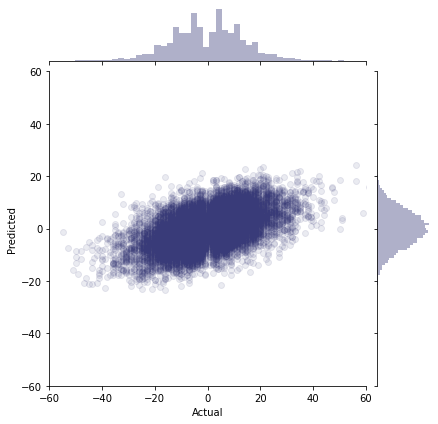

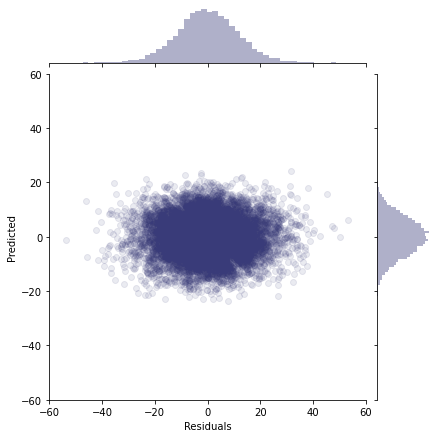

In [164]:
#took the lowest p-values from LASSO model kitchen sink

columns5 = ['const','Wins','PF_vs','Home_vs','Away_vs','Wins_vs','FT%_vs','3P%_S','PF']

model5, fit5, ypred5, prediction5, res_mat5 = train_diag(columns5, X_train, y_train, df_train)

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     382.6
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:09:51   Log-Likelihood:                -46166.
No. Observations:               12018   AIC:                         9.236e+04
Df Residuals:                   12004   BIC:                         9.246e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0809      0.103      0.786      0.4

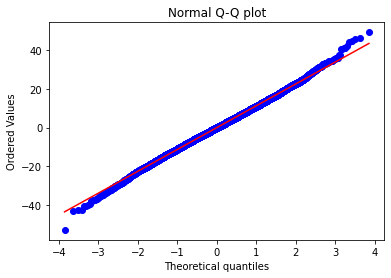

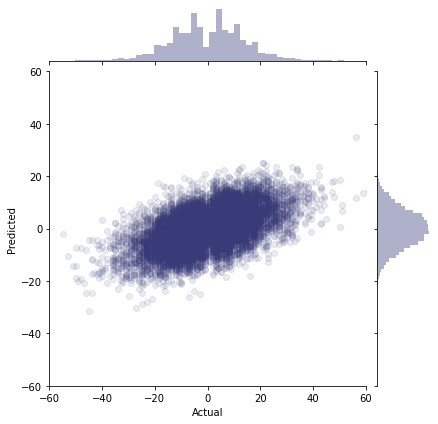

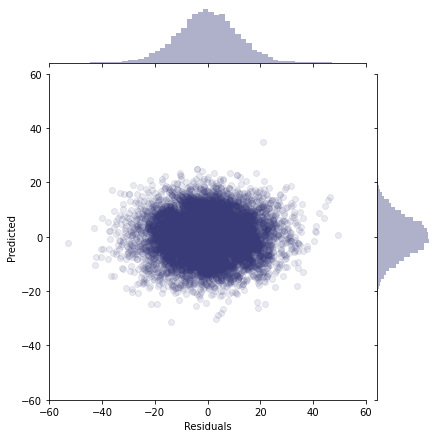

In [200]:
columns7 = ['const','Away','P_S','TRB%','AST%','STL%','BLK%','TS%','Pace','TRB%_vs','AST%_vs','STL%_vs','BLK%_vs','TS%_vs']

model7, fit7, ypred7, prediction7, res_mat7 = train_diag(columns7, X_train, y_train, df_train)